#### autoencoder (AE) is a neural network with two families of functions : the encoder family Eφ :x->z , parameterized by φ and decoder family Dθ : z->x parameterized by θ. Autoencoders try to create a smaller feature vector representation of input data such as images, which is called "bottleneck", using a first NN called encoder , and then reconstruct it by a second neural network called the decoder

In [1]:
!pip install torch torchvision pytorch_lightning>=1.4

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


label: cat


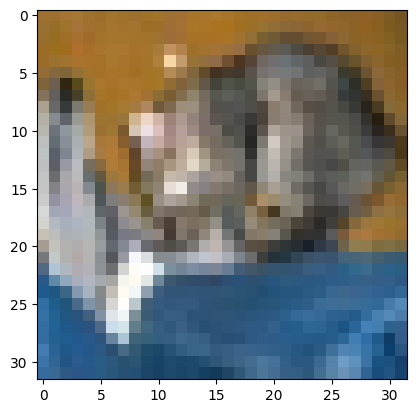

label: ship


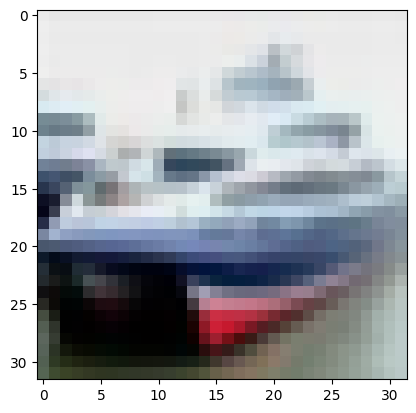

label: ship


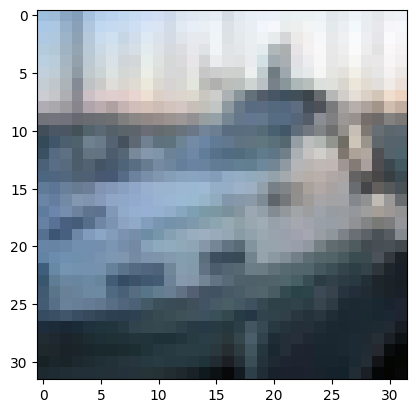

label: airplane


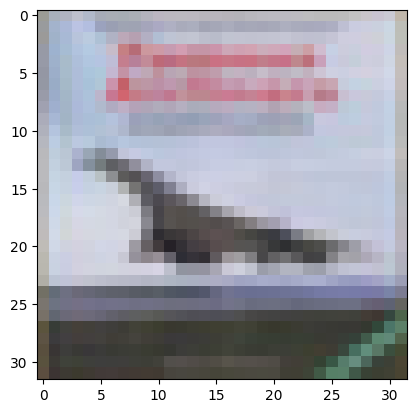

label: frog


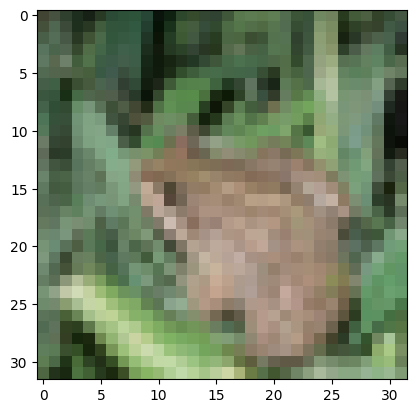

In [2]:
# lets first view the cifar dataset
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

test_data = CIFAR10(root='./view',train=False,download=True)

def view (i):
  img,label = test_data[i]
  print(f"label: {test_data.classes[label]}")
  plt.imshow(img)
  plt.show()

for i in range(5):
  view(i)

In [3]:
# creating the dataset for the model--we will be using cifar10 dataset
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl

# lets define the transformation that transforms our data to pytorch tensor and then normalize to -1 to 1 instead of 0 to 1

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

DATASET_PATH = './data'
train_dataset = CIFAR10(root=DATASET_PATH,train=True,transform = transform, download=True)
pl.seed_everything(42)
trans_set,val_set = torch.utils.data.random_split(train_dataset,[45000,5000])

test_set = CIFAR10(root=DATASET_PATH,train = False, transform=transform, download=True)

#defining the data loaders
train_loader = torch.utils.data.DataLoader(trans_set,batch_size=256,shuffle=True,drop_last=True,pin_memory=True,num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=256,shuffle=False,drop_last=True,pin_memory=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=256,shuffle=True,drop_last=True,pin_memory=True,num_workers=2)

# getting just the image tensors
def get_train_images(num):
  return torch.stack([train_dataset[i][0] for i in range(num)])


100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


#### an autoencoder consists of an encoder that maps the input x to a lower dimensional feature vector z and a decoder that reconstructs X̂ from z . we train the model by comparing x to X̂ and optimizing the parameters to increase the similarity between x and X̂. The encoder can me modeled by using multiple convolution layers.

In [4]:
import torch.nn as nn

class Encoder (nn.Module):

  def __init__(self,
               num_input_channels:int,
               base_channel_size:int,
               latent_dim:int,
               act_fn:object = nn.GELU):

    """Inputs:
    num_input_channels : number of channels in the images. for our case (cifar10) 3,
    base_channel_size : number of output channels of that layer i.e. number of feature matrices.
    latent_dim : dimensionality of latent representation of z
    act_fn : activation function used throughout the sequential layers.
    """

    super().__init__()

    c_hid = base_channel_size

    self.net = nn.Sequential(
        nn.Conv2d(num_input_channels,c_hid,kernel_size=3,padding=1,stride=2),  #32 x 32  --> 16 x 16  ....((n-k +2*p)/s +1)
        act_fn(),
        nn.Conv2d(c_hid,c_hid,kernel_size=3,padding=1),  # 16 x 16 --> 16 x 16
        act_fn(),
        nn.Conv2d(c_hid,2*c_hid,kernel_size=3,padding=1,stride=2), # 16 x 16 x c_hid -> 8 x 8 x 2*c_hid
        act_fn(),
        nn.Conv2d(2*c_hid,2*c_hid,kernel_size=3,padding=1), # 8 x 8 --> 8 x 8
        act_fn(),
        nn.Conv2d(2*c_hid,2*c_hid,kernel_size=3,padding=1,stride=2),  # 8 x 8 --> 4 x 4 x 2*c_hid
        act_fn(),
        nn.Flatten(), # flatenns the output features except the batch feature --- 2 * c_hid * 4 * 4
        nn.Linear(2*16*c_hid,latent_dim)
    )

  def forward(self,x):
    return self.net(x)


#### in the decoder side, we perform the transpose convolution. with the formula we obtain for a 3 x 3 input with 3 kernel,padding of 1 and stride 2, the output is 5 x 5 in a transpose convolution operation. However to truly have a reverse operation of the convolution we need to ensure that the layer scales the input by a factor of 2. i.e. 3 x 3 --> 6 x 6. So we add one row and one column to the output . this is specified with a parameter output_padding.

In [5]:
class Decoder (nn.Module):

  def __init__(self,num_input_channels:int,
               base_channel_size:int,
               latent_dim:int,
               act_fn:object = nn.GELU):

    super().__init__()
    c_hid = base_channel_size

    self.net = nn.Sequential (
        nn.ConvTranspose2d(2*c_hid,2*c_hid,kernel_size=3,output_padding=1,padding=1,stride=2), # 4 x 4 --> 8 x 8
        act_fn(),
        nn.ConvTranspose2d(2*c_hid,2*c_hid,kernel_size=3,padding=1), # 8 x 8 --> 8 x 8
        act_fn(),
        nn.ConvTranspose2d(2*c_hid,c_hid,kernel_size=3,output_padding=1,padding=1,stride=2), # 8 x 8 --> 16 x 16
        act_fn(),
        nn.ConvTranspose2d(c_hid,c_hid,kernel_size=3,padding=1), # 16 x 16 --> 16 x 16
        act_fn(),
        nn.ConvTranspose2d(c_hid,num_input_channels,kernel_size=3,padding=1,output_padding=1,stride=2), # 16 x 16 --> 32 x 32
        nn.Tanh() # since the input images were scaled -1 to 1 originally, now we use tanh.
    )

    # lets implement a linear layer that our latent representation first encounters in the decoder side
    self.linear = nn.Sequential(
        nn.Linear(latent_dim,2*16*c_hid),
        act_fn()
    )

  def forward(self,x):
    x = self.linear(x)
    x = x.reshape(x.shape[0],-1,4,4)
    x = self.net(x)
    return x

#### add the encoder and decoder together into the autoencoder architecture.

In [6]:
import torch.optim as optim
import torch.nn.functional as F

class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):

        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

#### our loss function here is mse. one thing to note with mse is that, mse sometime doesnot reflect the visual similarity of two images. for instance, if the reconstructed images from the autoencoder is just shifted by one pixel to the right and buttom, although the images will be seen identical, the loss we get a higher loss value than predicting a constant pixel value for half of the images.


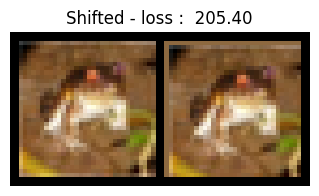

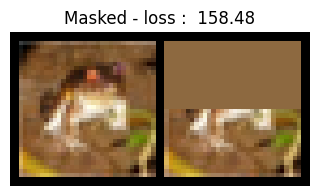

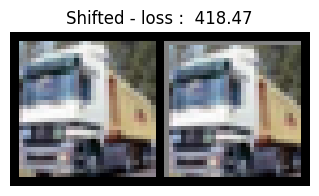

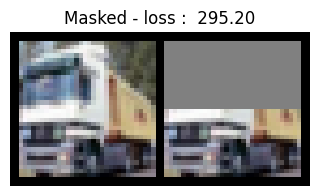

In [7]:
def compare_imgs(img1,img2,title=""):
  #calculating mse loss
  loss = F.mse_loss(img1,img2,reduction="sum")
  #plotting
  grid = torchvision.utils.make_grid(torch.stack([img1,img2],dim=0),nrow=2,normalize=True)
  grid = grid.permute(1,2,0)
  plt.figure(figsize=(4,2))
  plt.title(f"{title} loss : {loss.item(): 4.2f}")
  plt.imshow(grid)
  plt.axis('off')
  plt.show()

for i in range(2):
  img,_ = train_dataset[i]
  img_mean = img.mean(dim=[1,2],keepdims=True)

  # shift image by one pixel
  shift=1
  img_shifted = torch.roll(img,shifts=shift,dims=1) # shift across height
  img_shifted = torch.roll(img_shifted,shifts = shift,dims=2) # shift across width
  img_shifted[:,:1,:] = img_mean # replace the shifted row with mean pixel values
  img_shifted [:,:,:1] = img_mean
  compare_imgs(img,img_shifted,"Shifted -")

  # set half of the image to a single pixel value (mean)
  img_masked = img.clone()
  img_masked[:,:img_masked.shape[1]//2,:] = img_mean # replace the half of the image by mean value
  compare_imgs(img,img_masked,"Masked -")

## Training the Model

In [8]:
# to keep track of the learning progress we create a callback in pytoch lightning
import pytorch_lightning as pl

class GenerateCallback(pl.Callback):
  def __init__(self,input_imgs,every_n_epochs=1):
    super().__init__()
    self.input_imgs = input_imgs # images to reconstruct during training
    self.every_n_epochs= every_n_epochs

  def on_train_epoch_end(self,trainer,pl_module):
    if trainer.current_epoch % self.every_n_epochs == 0:
      # reconstruct images
      input_imgs = self.input_imgs.to(pl_module.device)

      with torch.no_grad():
        pl_module.eval()
        reconst_imgs = pl_module (input_imgs)
        pl_module.train()

      imgs = torch.stack([input_imgs,reconst_imgs],dim=1).flatten(0,1)
      grid = torchvision.utils.make_grid(imgs,nrow=2,normalize=True)
      trainer.logger.experiment.add_image("Reconstructions", grid, global_step = trainer.global_step)


In [9]:
# lets write the training function that allows us to train the model on different latent dimensions andn returns the test and validation scores.
import os
from pytorch_lightning.callbacks import ModelCheckpoint,LearningRateMonitor
CHECKPOINT_PATH = "./autoencoder/"
os.makedirs(CHECKPOINT_PATH,exist_ok=True)

def train_cifer(latent_dim):

  # creating a trainer
  trainer = pl.Trainer (default_root_dir = os.path.join(CHECKPOINT_PATH,f"cifar10_{latent_dim}"),
                        accelerator = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu",
                        devices =1,
                        max_epochs=50,
                        callbacks= [ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8),every_n_epochs=10),
                                    LearningRateMonitor("epoch")])

  trainer.logger._log_graph = True  # plot the coomputation graph in tensorboard
  trainer.logger._default_hp_metric = None

  # model define
  model = Autoencoder (base_channel_size = 32, latent_dim = latent_dim)
  trainer.fit(model,train_loader,val_loader)

  # testing the model on validation and test set
  val_result = trainer.test(model,val_loader,verbose = False)
  test_result = trainer.test (model,test_loader,verbose = False)
  result = {"test":test_result,"val":val_result}
  return model,result

#### The higher the latent dimension of z , the better the result. however since the idea of autoencoders is to somehow compress the data, we are also interested in keeping the dimensionality low. To find the best tradeoff, we shall start the exploration of latent dimension from 64 to 384

In [10]:
model_dict = {}
for latent_dim in [64,128,256,384]:
  model_ld,result_ld = train_cifer(latent_dim)
  model_dict[latent_dim]= {"model":model_ld,"result":result_ld}

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 168 K  | train
1 | decoder | Decoder | 168 K  | train
--------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/tensorboard.py:195: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 233 K  | train
1 | decoder | Decoder | 234 K  | train
--------------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.873     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 364 K  | train
1 | decoder | Decoder | 365 K  | train
--------------------------------------------
730 K     Trainable params
0         Non-trainable params
730 K     Total params
2.922     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 496 K  | train
1 | decoder | Decoder | 496 K  | train
--------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.971     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

#### now lets plot the reconstruction against the latent dimension

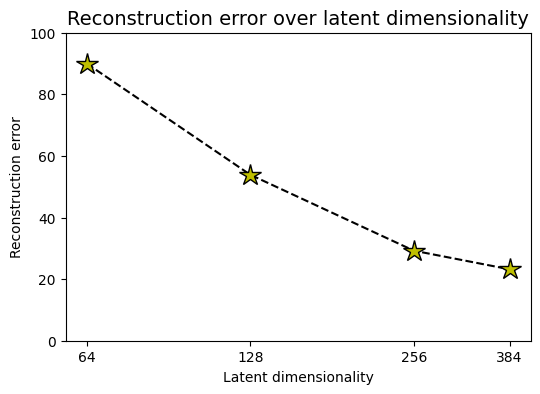

In [12]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

In [20]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

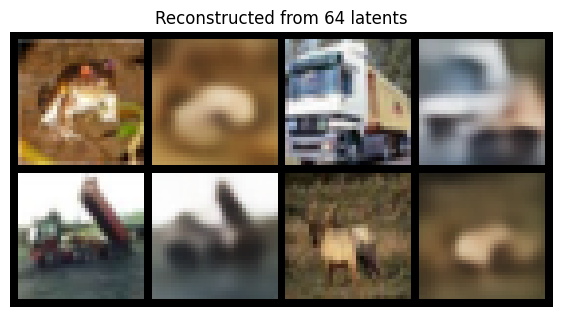

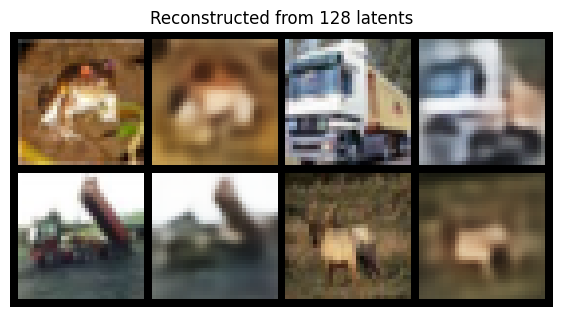

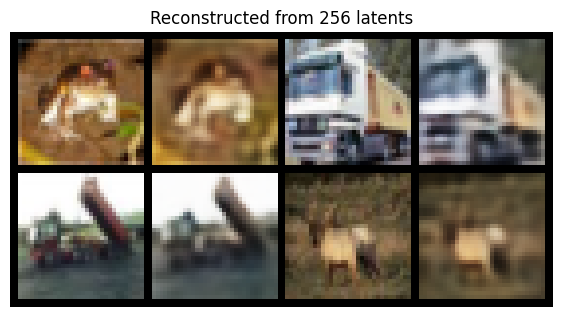

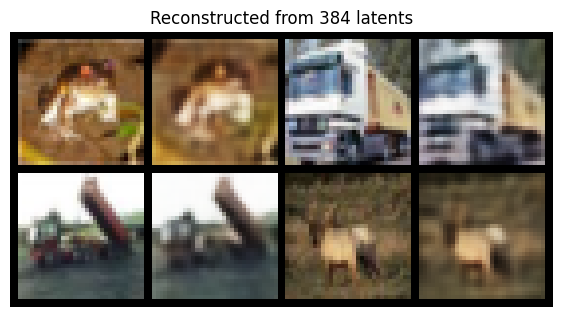

In [21]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

#### we can see that the smallest latent dimensionality can only understand the rough shape and color of the object. The models with higher latent dimensions reconstruct the images quite well, though the models are trained just for 50 epochs.

### But, what if we use this autoencoder to reconstruct an image that is clearly out of distribution of our input dataset that the model is trained on. lets just try with a random noise.

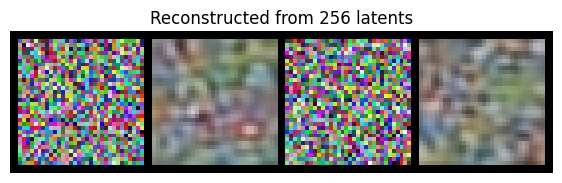

In [22]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1 # random noise images scaled from -1 to 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

#### Thus we see that , the model actually performed very poorly on the data it has not seen before. The reason for this is that, the model has learned some pattern in the input dataset, and when the input is not following that pattern, its really hard for the decoder to reconstruct it back.

## what about generating new images ?

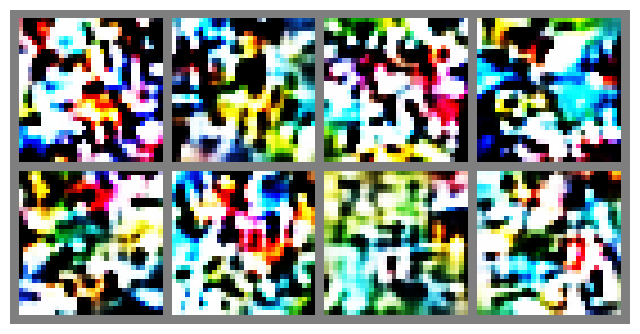

In [29]:
# lets pass a random latent vectors into the decoder and see what it generates.
model = model_dict[384]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2,0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

#### Thus we see that, the generated images look more like some sort of art than realistic images. As the autoencoder was allowed to represent the latent space in whichever way it suits the reconstruction best, it has not learned to map every possible latent vector into realistic images. Also the distribution of latent space is unknown to us. So we can infer that vanilla autoenoders are indeed not generative . Variational Autoencoders (VAEs) are generative version of autoencoders where we train the models to represent the latent space as a gaussian distribution. However, here in vanilla autoencoders we donot have any restriction on the latent vector.

#### One other application of autoencoders can be to build a simple image based search engine. Like finding visually similar images based on the input image. For that we can first encode all the images into their respective latent vector representation and then find  similarity between the vectors using euclidian or cosine distance.